In [12]:
import os
import pandas
import misc
import preprocessing
import integrity
import matplotlib.pyplot as pyplot

# Initialize empty lists to store experiment names and their corresponding summary data
experiment_names = list()
experiment_summaries = list()

# Define the site path for accessing experiment data
site = 'DATA'

# Retrieve a list of directories (experiments) for the specified site using a custom function
directories, _ = misc.get_IT_list(site)

# Iterate through each directory, assigning an experiment number and extracting data
for experiment_number, path in enumerate(directories):
    # Assign the current experiment number as the ID
    experiment_id = experiment_number
    # Extract the experiment name from the last component of the directory path
    experiment_name = os.path.basename(path)
    # Append the experiment name to the list
    experiment_names.append(experiment_name)

    # Attempt to load experiment data and cycles from the directory
    try:
        data, cycles = preprocessing.load_experiment(path)
    # Handle any exceptions during data loading, print the error, and retry loading
    except Exception as e:
        print(e, experiment_id, experiment_name)
        data, cycles = preprocessing.load_experiment(path)

    # Initialize a dictionary to store datapoints for specific channels
    datapoints = dict()

    # Define cycles to exclude from analysis (e.g., cycle 0)
    exclude = [0]
    # Specify the input channel for analysis
    channels = ['Concentrate Pressure (psi)']
    # Define the target channel for corrected data
    target_channel = 'Corrected Concentrate Pressure (psi)'

    # Set flags for applying conductivity and temperature compensation
    conductivity_compensation = True
    temperature_compensation = True
    # Specify the model type for corrections
    model = 'ratio'

    # Iterate through each specified channel to process data
    for channel in channels:
        # Initialize an empty list to store datapoints for the current channel
        datapoints[channel] = list()

        # Process each cycle in the experiment, gathering data at specified conditions
        for i, cycle in enumerate(cycles):
            # Skip cycles marked for exclusion
            if i in exclude:
                continue
            else:
                # Attempt to apply corrections and extract data
                try:
                    # Apply conductivity correction only if enabled and temperature correction is disabled
                    if conductivity_compensation and not temperature_compensation:
                        cycle['Corrected Concentrate Pressure (psi)'] = integrity.conductivity_correction(
                            cycle['Concentrate Conductivity (mS/cm)'],
                            cycle['Concentrate Pressure (psi)'], model=model)

                    # Apply temperature correction only if enabled and conductivity correction is disabled
                    elif not conductivity_compensation and temperature_compensation:
                        cycle['Corrected Concentrate Pressure (psi)'] = integrity.temperature_correction(
                            cycle['Concentrate Temperature (C)'],
                            cycle['Concentrate Pressure (psi)'],
                            model=model)

                    # Apply both conductivity and temperature corrections if both are enabled
                    elif conductivity_compensation and temperature_compensation:
                        cycle['Corrected Concentrate Pressure (psi)'] = integrity.normalize_concentrate_pressure(
                            cycle['Concentrate Temperature (C)'],
                            cycle['Concentrate Conductivity (mS/cm)'],
                            cycle['Concentrate Pressure (psi)'], model=model)
                    # If no corrections are applied, use the raw concentrate pressure
                    else:
                        cycle['Corrected Concentrate Pressure (psi)'] = cycle['Concentrate Pressure (psi)']

                    # Extract the first datapoint for the target channel where Cycle Recovery is at least 30%
                    datapoint = cycle[cycle['Cycle Recovery (%)'] >= 30].iloc[0][target_channel]
                    # Append the datapoint to the channel's list
                    datapoints[channel].append(datapoint)
                # Handle any exceptions during data processing, print the error, and stop processing the current cycle
                except Exception as e:
                    print(e)
                    break

    # Create a DataFrame from the collected datapoints for the current experiment
    summary = pandas.DataFrame(datapoints)
    # Append the summary DataFrame to the list of experiment summaries
    experiment_summaries.append(summary)

/tmp/ipykernel_46031/3185044423.py:16: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(summaries, labels=experiment_names)


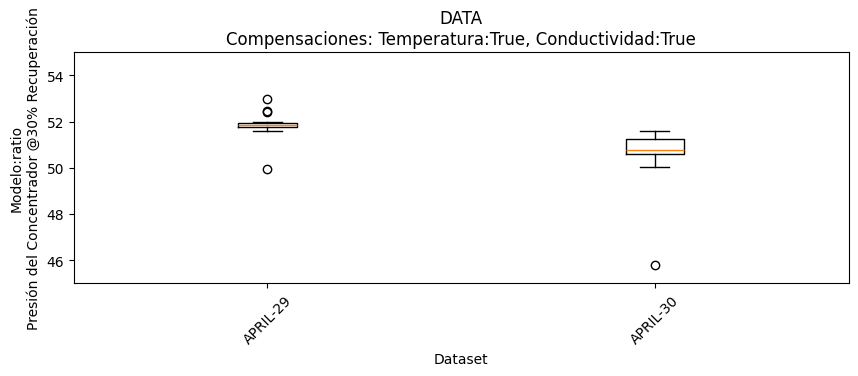

In [13]:
# Inicializar una lista vacía para almacenar los datos de los resúmenes por canal
# Initialize an empty list to store the summary data for the channel
summaries = list()

# Iterar sobre los resúmenes de experimentos y extraer los datos del canal especificado
# Iterate over experiment summaries and extract data for the specified channel
for experiment_summary in experiment_summaries:
    summaries.append(experiment_summary[channel])

# Crear una figura y un eje para el gráfico de caja con un tamaño definido para mejor visibilidad
# Create a figure and axis for the boxplot with a set size for better visibility
fig, ax = pyplot.subplots(figsize=(10, 3))

# Generar un gráfico de caja con los datos de los resúmenes y etiquetas de los nombres de experimentos
# Generate a boxplot with the summary data and experiment names as labels
ax.boxplot(summaries, labels=experiment_names)

# Establecer el título del gráfico, incluyendo el sitio y las compensaciones aplicadas
# Set the plot title, including the site and applied compensations
ax.set_title(f"{site}\nCompensaciones: Temperatura:{temperature_compensation}, Conductividad:{conductivity_compensation}")

# Etiquetar el eje X como 'Dataset' (conjunto de datos)
# Label the X-axis as 'Dataset'
ax.set_xlabel('Dataset')

# Etiquetar el eje Y con el modelo y la descripción de la presión del concentrado a 30% de recuperación
# Label the Y-axis with the model and description of concentrate pressure at 30% recovery
ax.set_ylabel(f'Modelo:{model}\nPresión del Concentrador @30% Recuperación')

# Establecer límites en el eje Y para enfocar la visualización en el rango de 45 a 55
# Set Y-axis limits to focus the visualization in the range of 45 to 55
pyplot.ylim(45, 55)

# Rotar las etiquetas del eje X 45 grados para mejorar la legibilidad si los nombres son largos
# Rotate X-axis labels 45 degrees for readability if names are long
pyplot.xticks(rotation=45)

# Mostrar el gráfico
# Display the plot
pyplot.show()